<center> <img src = "https://images.theconversation.com/files/442675/original/file-20220126-17-1i0g402.jpg" style = "height:420px; width:960px; opacity: 1"/><center/>

# <center> Exploratory analysis of meteorological data <center/>

In this notebook, we display some practical data visualization techniques for analysing weather data. The dataset used in this example consists of measurements of several weather instruments, captured every 10 minutes, from the weather station of the **Max-Planck-Institute for Biogeochemistry in Jena, Germany in 2020**, and can be accessed with the following [**link**]( https://paperswithcode.com/dataset/weather-ltsf). For further details of the measured variables in the dataset, one should refer to the [**Documentation**](https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf) issued by the Max-Plank-Institude.

The notebook is structured as following:
- [Ridge Plot](#ridge)
- [Boxplot and Swarm Plot](#bspl)
- [Line Plot](#line)
- [Barplot](#barp)
- [Heatmap](#heat)
    - [Example 1](#ex1)
    - [Example 2](#ex2)
- [Deriving variables](#Definitions)
- [Formulas](#formulas) 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import  LinearSegmentedColormap

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
path = "../Data/"
filename = "Max_Planck_Institute_weather_dataset_2020.csv"
data = pd.read_csv(path + filename)

In [3]:
# Define functions 
## For data processing
def filter_column_name(column_name): # removes everything within the parenthesis
    try:
        idx = column_name.index("(") - 1
        return column_name[:idx]
        
    except ValueError: # the string doesn't contain any parenthesis
        return column_name
        
## For plotting
def modify_cmap(cmap_name, range, name): # modifies the color range of colormaps
    start, end, n_colors = range
    c_map = plt.cm.get_cmap(cmap_name)
    segment = [c_map(x) for x in np.linspace(start, end, n_colors)]
    custom_cmap = LinearSegmentedColormap.from_list(name, segment)
    return custom_cmap

In [4]:
# Process dataset
columns = [filter_column_name(x) for x in data.columns]
data.rename(columns={x:y for x, y in zip(data.columns, columns)}, inplace=True)
data['date'] = data.date.apply(pd.to_datetime)
data['month'] = data.date.dt.month.values
data['day'] = data.date.dt.day.values
data['day_nb'] = data.date.dt.dayofyear.values
data.drop(52695, inplace=True)

<a id="ridge"></a>
## Ridge Plot

The representation of data using a ridge plot, also known as a ridgeline plot, shows the distribution of the different subsamples of a data set, either for a specific variable or for multiple variables that make up the data set. This representation is characterized by overlapping distributions, which simplifies the recognition of patterns within the data.

In [5]:
def display_ridge_plot(data, category, hour, minute, second=[0], day=list(range(1, 32)), month=list(range(1, 13)), year=[2020], label="", title=""):
    # Data processing
    data = data[data.date.apply(lambda x: (x.year in year) and (x.month in month) and (x.day in day) and (x.hour in hour) and (x.minute in minute)\
                               and (x.second in second))]
    data['month'] = data.date.apply(lambda x: x.month)
    mean_cat_map = data[[category, 'month']].groupby('month')[category].mean()
    data[f"mean_{category}_month"] = data['month'].map(mean_cat_map)
    
    # Plot
    palette = sns.color_palette(palette='coolwarm', n_colors=12)
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 
          10: 'October', 11: 'November', 12: 'December'}

    grid = sns.FacetGrid(data, row='month', hue=f"mean_{category}_month", aspect=15, height=0.5, palette=palette)
    grid.map(sns.kdeplot, category, bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    grid.map(sns.kdeplot, category, bw_adjust=1, clip_on=False, color="w", lw=2)
    grid.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    list_months = [months[x] for x in data.month.unique()]
    for i, ax in enumerate(grid.axes.flat):
        ax.text(0, 0.02, list_months[i], fontweight='bold', fontsize=10, color=ax.lines[-1].get_color(), transform=ax.transAxes)
        
    # Show overlaps by hidding ax backgrounds
        ax.patch.set_alpha(0)
        
    grid.fig.subplots_adjust(hspace=-0.3) 
    grid.despine(bottom=True, left=True)
    grid.set_titles("")
    grid.set(yticks=[], ylabel="")
    grid.set_axis_labels(label, "", fontweight='bold', fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold') # tick labels
    
    grid.fig.suptitle(title, fontsize=10, fontweight=20)
    plt.show()

The example below shows the distributions of temperatures measured, by month, at the Max Plank Institute's weather station, for the year 2020. </br>
Notice that between the temperatures presented here, no distinction is made between nighttime and daytime, leaving an overview of the climate without getting into finer details.

As can be seen, the first three months of 2020 were mostly cold, as well as the months of December and, to a lesser extent, November.
Looking closer, the cold temperatures of January are highlighted by the presence of a small bump on the left-hand side of the distribution.
Temperatures remained in a similar bracket for the following two months, only slightly warmer than in January. From April onwards, temperatures began to rise, showing a warm -but not hot- summer, with the exception of an isolated day in August. 
We should also mention the uniformity in the distribution of temperatures between April and July, since this is quite a peculiar event.
A contrast in temperatures is also noticeable between August and September, signaling the arrival of autumn, from which point onwards the drop in temperatures becomes more marked. 
A cold end of the year was observed, with temperatures recorded in December being mostly between 0 and 5 ºC, which makes it the coldest month of the year.


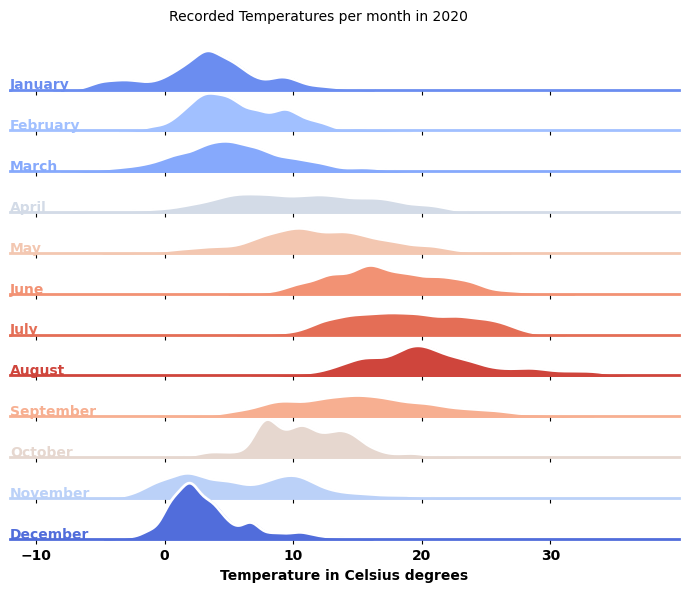

CPU times: total: 109 ms
Wall time: 1.82 s


In [6]:
%%time
hour = list(range(24))
minute = list(range(60))
title = "Recorded Temperatures per month in 2020"
label = "Temperature in Celsius degrees"
args = dict(hour=hour, minute=minute, title=title, label=label)

display_ridge_plot(data, 'T', **args)

<a id="bspl"></a>
## Boxplot and Swarm plot

As we have already mentioned in the [**Notebook**](https://github.com/achrafkr/Data-Visualization/blob/main/Notebooks/Football_stats.ipynb) on the visualization of soccer data, boxplots are used to present the distribution of quantitative data, are particularly relevant for the analysis of the spread of data within quartiles. In addition, boxplots become an interesting tool for identyfing outliers -if present- within the dataset.

To add more clarity to plots, boxplots can be complemented with a swarm plot, which basically means the discrete distribution of the data in form of non-overlapping scattered dots. Swarm plots are typically useful as a complement to a more common analysis tools such as the previously mentioned boxplots, or violin plots, for instance. However, this method does not provide a meaningful insight for large datasets, as the points will overlap each other.

In [7]:
# Set style parameters
rc = {"grid.color": ".6", "grid.linestyle": "dotted"}
sns.set_style("darkgrid", rc=rc)

In [8]:
def display_box_plot(data, category, hour, minute, second=[0], day=list(range(1, 32)), month=list(range(1, 13)), year=[2020], label="", title="", ax=None):
     # Data processing
    data = data[data.date.apply(lambda x: (x.year in year) and (x.month in month) and (x.day in day) and (x.hour in hour) and (x.minute in minute)\
                               and (x.second in second))]
    data['month'] = data.date.apply(lambda x: x.month)
    mean_cat_map = data[[category, 'month']].groupby('month')[category].mean()
    data[f"mean_{category}_month"] = data['month'].map(mean_cat_map)
    
    # Plot
    palette = sns.color_palette(palette='coolwarm', n_colors=12)
    months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 
          10: 'October', 11: 'November', 12: 'December'}
    f = lambda x: months[x] if x in range(1, 13) else None

    sns.boxplot(data, x='month', y=category, ax=ax, boxprops={"alpha": 0.6}).set(title=title)
    sns.swarmplot(data, x='month', y=category, alpha=1, marker='.', ax=ax, hue='month', palette='husl', legend=None)
   
    plt.xticks(range(12), map(f, range(1, 13)), rotation=30)
    
    plt.show() if ax is None else None

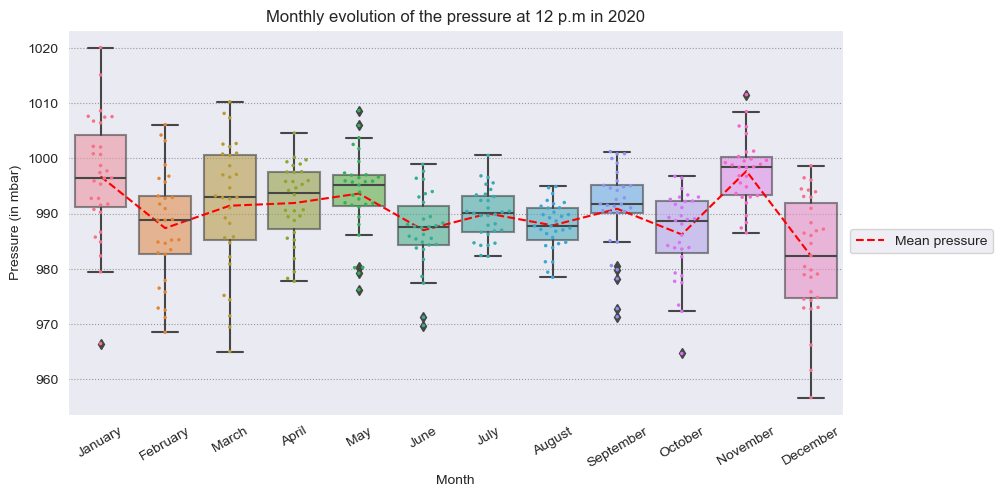

CPU times: total: 15.6 ms
Wall time: 377 ms


In [10]:
%%time
fig, ax = plt.subplots(figsize=(10, 5))

hour = [12]
minute = [0]
title = "Monthly evolution of the pressure at 12 p.m in 2020"
args = dict(hour=hour, minute=minute, title=title, label=label)

display_box_plot(data, 'p', ax=ax, **args)

# Adding mean pressure line
ax.plot(np.arange(12), data[data.date.apply(lambda x: x.hour == 12 and x.minute == 0)].groupby(['month'])['p'].mean(), color='red', \
       linestyle='dashed', label='Mean pressure')
ax.set_xlabel('Month')
ax.set_ylabel('Pressure (in mbar)')
ax.legend(bbox_to_anchor=(1, 0.5))
plt.show()

<a id="line"></a>
## Line Plot

Perhaps one of the most conventional data representation techniques. It is particularly useful for time series, since it allows us to follow the evolution of the variable over time, as well as to visualize the trend and seasonality, in addition to other characteristics of a time series. 
In addition, filling in the gaps attracts the reader's attention, and also stresses the contrast of disparate values within the representation.

In [11]:
# Adding new variable
acummulated_rain_map = data[['rain', 'day_nb']].groupby('day_nb')['rain'].sum()
data['acc_rain'] = data['day_nb'].map(acummulated_rain_map)
acummulated_rain_time_map = data[["day_nb", "raining"]].groupby("day_nb")['raining'].sum()/60
data['acc_rain_time'] = data['day_nb'].map(acummulated_rain_time_map)

In [12]:
def line_plot(x, y, title="", labels=["", "", ""], color="tab:blue", fcolor="navy", ax=None, t_labels=None, xticks=None, rotation=60):
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 5))

    ax.plot(x, y, color=color, label=labels[0], linewidth=1.25)
    ax.fill(x, y, color=fcolor, alpha=.45)
    ax.set_xticks(ticks=xticks, labels=t_labels, rotation=rotation) if (t_labels is not None and xticks is not None) else None
    ax.set_title(title, fontsize=14, fontweight=20)
    ax.set_xlabel(labels[1], fontsize=12)
    ax.set_ylabel(labels[2])
    # Dealing with legend
    h, l = ax.get_legend_handles_labels()
    ax.legend(handles=h, labels=l) if l[0] not in ["", None] else None
    plt.show() if ax is None else None

This figure shows the cumulative rainfall per day (blue) along with the average rainfall rate (red) per hour, over the year 2020.
Rainy days are particularly frequent (blue curve) between February and the first half of March, as well as the first half of June, followed by August and October. In terms of intensity (red curve), for the most part of the year, we observe light and moderate precipitation **[[1](https://glossary.ametsoc.org/wiki/Rain)]**.
We may also stress the marginal occurrence of intense rainfall days that only last for a very short time (less than an hour).
Regarding the rainiest days, in the absence of more in-depth analysis, this graph suggests that these days are characterized by moderate rainfall lasting all day long.

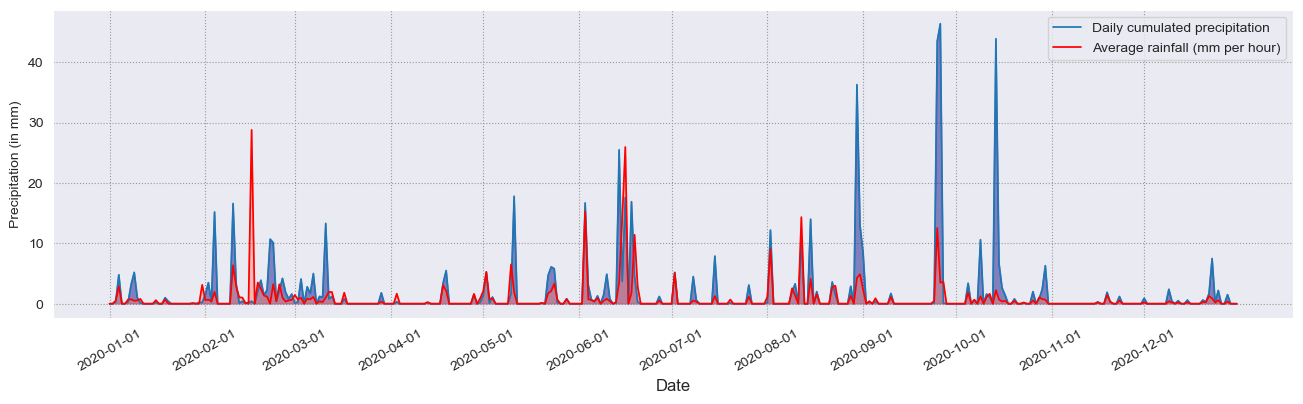

In [13]:
fig, ax = plt.subplots(figsize=(16, 4))

x = data.drop_duplicates(['day_nb', 'acc_rain']).date.dt.date.values
y = data.drop_duplicates(['day_nb', 'acc_rain']).acc_rain.values
y_ = data.drop_duplicates(['day_nb', 'acc_rain_time']).acc_rain_time.values
xlab = [date for date in x if date.day == 1] # tick labels

args = dict(ax=ax, xticks=xlab, t_labels=xlab, title="Precipitation in 2020",
           labels=["Daily cumulated precipitation", "Date", "Precipitation (in mm)"], rotation=30)

args_ = dict(ax=ax, xticks=xlab, t_labels=xlab, color="red", fcolor="salmon",
           labels=["Average rainfall (mm per hour)", "Date", "Precipitation (in mm)"], rotation=30)

line_plot(x, y, **args)
line_plot(x, [(60*v/v_) if (v_!=0) else 0 for (v,v_) in zip(y, y_)], **args_)
plt.show()

<a id="barp"></a>
## Barplot

Barplots are also a common approach for plotting data. Barplots are for quantitative variables and can be used to illustrate the evolution of a single or more variables, i.e., like line plots, they can be used to represent time series. They are also suitable for making comparisons between variables, or among the various categories or subsets that make up a variable.

In [14]:
# Extracting data into temporal dataframes
summer_prec = data.query("'2020-06-01' <= date < '2020-09-01'").groupby(['day_nb'])[['date', 'acc_rain']].mean() # dates of meteorological summer
mean_prec = summer_prec.acc_rain.mean()
summer_prec['acc_rain'] = summer_prec.acc_rain.apply(lambda x: x-mean_prec)
summer_prec['sign'] = summer_prec.acc_rain.apply(lambda x: np.sign(x)).astype(str)

The fluctuation of accumulated precipitation in relation to the summer average is depicted in the figure below.
Red shows virtually dry days and green shows two distinct categories: low-intensity rainfall days, i.e. light rain, and days of heavy to moderate rainfall. With this method, it is much easier to spot anomalies i.e. days with excessive rainfall, and when applied to larger data sets, it can also provide valuable insights for finding seasonal patterns.

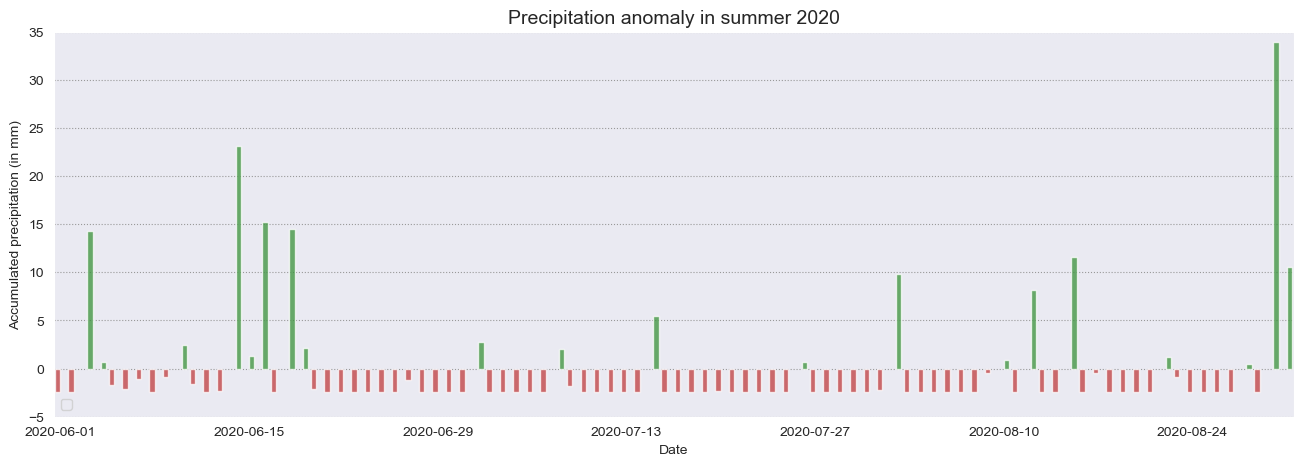

In [15]:
fig, ax = plt.subplots(figsize=(16, 5))

sns.barplot(summer_prec, x='date', y='acc_rain', hue='sign', palette=sns.color_palette()[2:4][::-1], alpha=.75, ax=ax)
ticks = range(0, len(summer_prec), 14)
labels = summer_prec.date.dt.date.values[::14]
miny, maxy = np.round(summer_prec.acc_rain.min(), -1) - 5, np.round(summer_prec.acc_rain.max(), -1) + 5
ax.set_xticks(ticks=ticks, labels=labels, rotation=0)
ax.set_ylim(miny, maxy)
ax.set_xlabel("Date")
ax.set_ylabel("Accumulated precipitation (in mm)")
ax.set_title("Precipitation anomaly in summer 2020", fontsize=14)
ax.legend([])

plt.show()

<a id="heat"></a>
## Heatmap

Let's now turn to heat maps. As previously mentioned in **[[2](https://github.com/achrafkr/Data-Visualization/blob/main/Notebooks/Football_stats.ipynb)]**, heat maps are particularly useful for describing the impact between two or more variables. 
These techniques are employed exclusively with quantitative variables, and their scope of application is limited only by the human imagination.

In this particular case, the variables will be selected on the basis of two distinctive purposes. Consequently, the initial step will be to identify the variables that are pertinent to each objective.

In [16]:
# Extracting data into temporal dataframes
df_tmp = data.query("month==6").copy()
df_tmp['hour'] = df_tmp.date.dt.hour.values
df_tmp = df_tmp.groupby(['day', 'hour'])[['rain', 'T']].sum()

rainfall = np.zeros((24, 30))
heat = np.zeros((24, 30))
for i in range(1, 31):
    rainfall[:, i-1] = df_tmp.rain.loc[i].values.reshape(-1)
    heat[:, i-1] = df_tmp['T'].loc[i].values.reshape(-1)/6
    
rainfall = pd.DataFrame(rainfall, columns=range(1, 31), index=range(24))
heat = pd.DataFrame(heat, columns=range(1, 31), index=range(24))

#del df_tmp

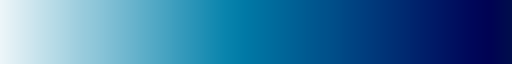

In [17]:
custom_cmap = modify_cmap('ocean_r', (0.025, 0.7, 26), 'Ocean_custom')

custom_cmap

<a id="ex1"></a>
### Example 1

Our first example focuses on the month of June, which was one of the rainiest periods of 2020. Heat maps are particularly helpful to study the relationship between temperature and precipitation, as they provide a more detailed approach by allowing us to look at 3 variables simultaneously  (day, time and temperature or precipitation). 

One of particularly striking details is the high concentration of (heavy) rainfall at certain times. Furthermore, such events indicate the transition leading to an appreciable drop in temperatures.

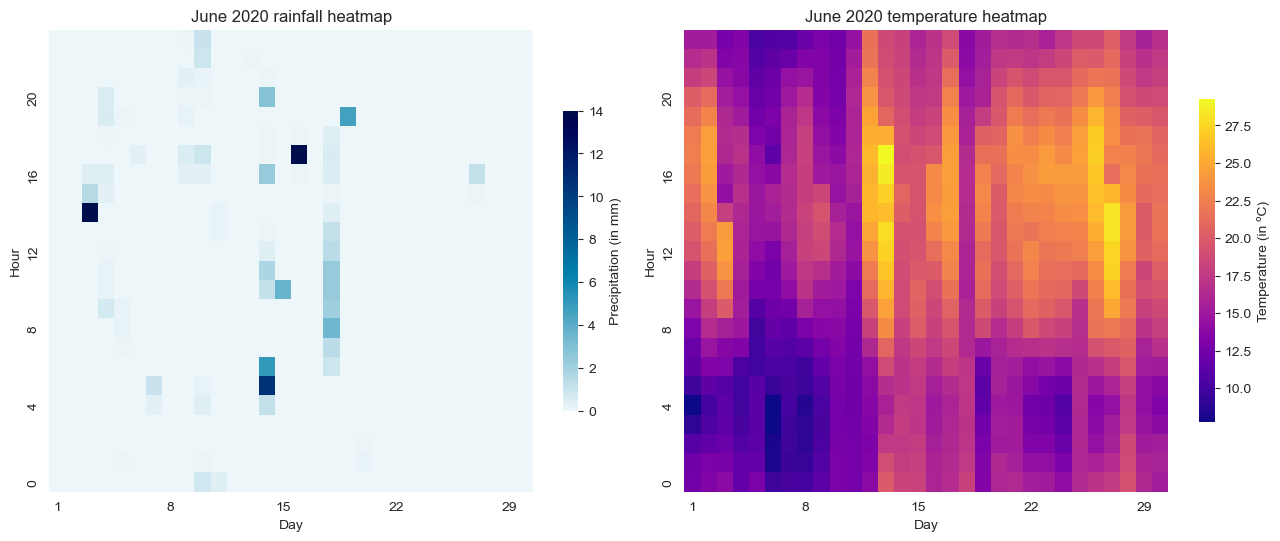

CPU times: total: 78.1 ms
Wall time: 413 ms


In [18]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.05)
# Rainfall heatmap
sns.heatmap(rainfall, vmax=14, cmap=custom_cmap, cbar_kws=dict(shrink=.65, label="Precipitation (in mm)"), ax=ax[0])
# Tempearture heatmap
sns.heatmap(heat, cmap='plasma', cbar_kws=dict(shrink=.7, label="Temperature (in ºC)"), ax=ax[1])

for ax_, title in zip(ax.ravel(), ['rainfall', 'temperature']):
    ax_.set_title("June 2020 {} heatmap".format(title), fontsize=12)
    ax_.set_xticks(ticks=np.arange(0, 30, 7)+0.5, labels=range(1, 31, 7), rotation=0)
    ax_.set_yticks(ticks=np.arange(0, 23, 4)+0.5, labels=range(0, 23, 4))
    ax_.invert_yaxis()
    ax_.set_ylabel("Hour")
    ax_.set_xlabel("Day")

plt.show()

<a id="ex2"></a>
### Example 2

In [43]:
columns = ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 'sh',
       'H2OC', 'rho', 'wv', 'max. wv', 'wd', 'rain', 'raining', 'SWDR', 'PAR']

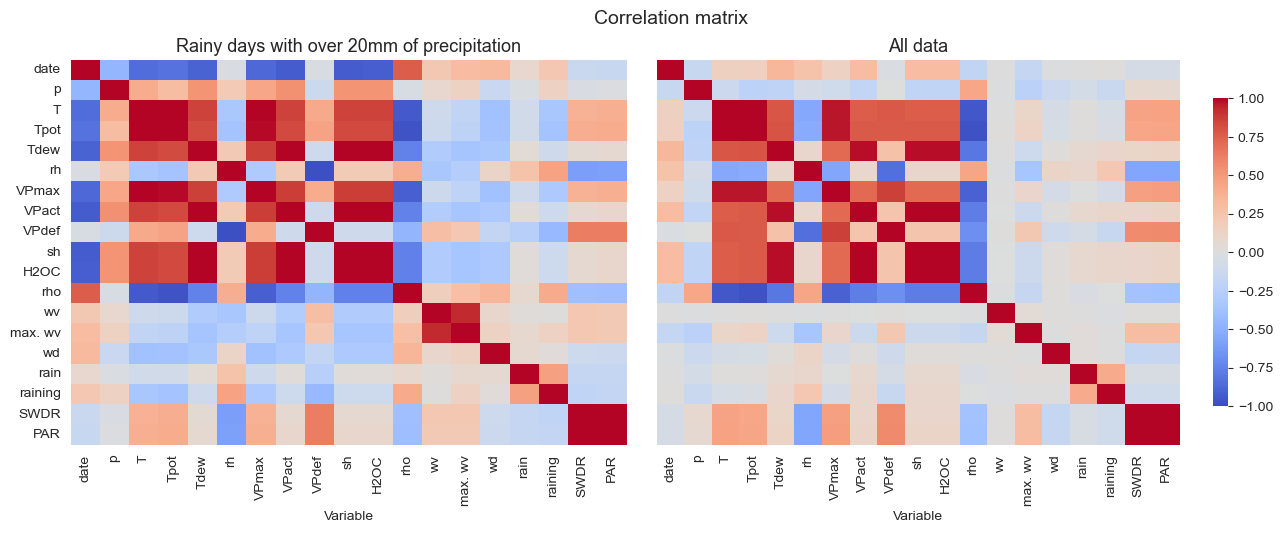

CPU times: total: 31.2 ms
Wall time: 486 ms


In [53]:
%%time
fig, ax = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [0.85, 1]})
fig.subplots_adjust(wspace=0.05)
# heatmap
sns.heatmap(data[data.acc_rain.values > 20][columns].corr(), vmin=-1, vmax=1, cmap="coolwarm", cbar=None, ax=ax[0])
sns.heatmap(data[columns].corr(), vmin=-1, vmax=1, cmap='coolwarm', cbar_kws=dict(shrink=.8), ax=ax[1])

for (i, ax_), title in zip(enumerate(ax.ravel()), ['Rainy days with over 20mm of precipitation', 'All data']):
    ax_.set_title("{}".format(title), fontsize=13)
    ax_.set_xlabel("Variable")
    ax_.set_yticks([]) if i>0 else None
    
plt.suptitle("Correlation matrix", fontsize=14)
plt.show()

In [ ]:
%%time
fig, ax = plt.subplots(1, figsize=(16, 6))
fig.subplots_adjust(wspace=0.05)
# Daylight heatmap
sns.heatmap(data[["date", "month", "SWDR"]].query("month==1"), cmap='plasma', cbar_kws=dict(shrink=.7, label="Solar radiation ($Wm^{-2}$"), ax=ax[1])

ax.set_title("Sunrise & Sunset with Twilight in January 2020 in Jena".format(title), fontsize=12)
ax.set_xticks(ticks=np.arange(0, 30, 7)+0.5, labels=range(1, 31, 7), rotation=0)
ax.set_yticks(ticks=np.arange(0, 23, 4)+0.5, labels=range(0, 23, 4))
ax.invert_yaxis()
ax.set_ylabel("Hour")
ax.set_xlabel("Day")

plt.show()

<a id="Definitions"></a>
# Deriving variables

A partir de las variables de las que disponemos, es posible definir nuevas variables que permiten un analisis más qualitativo (más orientado hacia las sensaciones del ser humano) de las magnitudes físicas, y particularmente la temperatura. En nuestro caso vamos a utilizar la sensación térmica, y la temperatura aparente para mostrar el impacto de las temperaturas sobre el ser humano.
En nuestro caso, dado que para calcular la temperatura aparente, es necesario disponer de la radiación solar neta absorvida, algo que no tenemos, hemos decidido estimar esta variable, basandonos en el procedimiento detallado por **[[3](link1)]** y **[[4](link2)]**.

By leveraging the available variables, we can introduce new variables that provide a more qualitative assessment (more focused on human sensations) of physical quantities, particularly temperature. In this instance, we will be estimating the wind chill and the apparent temperature in order to provide an insight into the impact of temperatures on humans.


However, since the net absorbed solar radiation is required to calculate the apparent temperature, and we do not have access to this data, as an alternative, we have decided to estimate this variable following the approach proposed by **[[3](https://doi.org/10.1016/j.jrmge.2016.10.004)]** and **[[4](https://doi.org/10.1016/j.ijheatmasstransfer.2013.03.031)]**.

The **Wind Chill** ($W_{c}$) describes the effect of the wind on how the human body perceives temperatures. The standard formula defines the wind chill as a non linear combination of the air temperature and wind speed:
$$ W_{c} = 13.12 + 0.6215 T_{a} + (0.3965 T_{a} - 11.37) v ^{0.16}$$
where $T_{a}$ and $v$ represent respectively the **Air temperature** (in ºC) and the **Wind speed** (in km/h).

Another indicator of how temperature is perceived by our body, is the **Apparent Temperature** ($A_{T}$). This metric describes what the temperature feels like to the human body when relative humidity is combined with the air temperature, wind chill and solar radiation. It is defined as following:
$$ A_{T} = T_{a} + 0.348 e_{a} - 0.70 v + 0.70 \frac{R_{n}}{v + 10} - 4.25$$
where $T_{a}$, $e_{a}$, $v$ and $R_{n}$ are respectively the **Air temperature**, the **(Water) vapor pressure**, the **Wind speed** and the **Net absorved (solar) radiation**. 

The **Net absorved radiation** can be approximated using the following formula, that takes into account the air and soil radiation emissivity:
$$ R_{n} = (1-\alpha)R_{s} - \varepsilon_{s}(\sigma T_{s})^{4} + \varepsilon_{a}(\sigma T_{a})^{4} $$
where $\alpha$ is the albedo, $R_{s}$ the solar radiation, $\varepsilon_{s}$ the soil surface emissivity, $\varepsilon_{a}$ the air emissivity, $T_{a}$ the air temperature and $T_{s}$ the soil temperature. For its part, $\sigma$ represents the **Stefan–Boltzmann constant** $\big(\sigma = 5.67 × 10^{−8} W/(m^{2} K^{4})\big)$.

The value for soil surface emissivity ($\varepsilon_{s}$) and the formula for air emissivity ($\varepsilon_{a}$) are provided in **[[3](https://doi.org/10.1016/j.jrmge.2016.10.004)]**:
$$ \varepsilon_{a} = 0.7 + 5.95 \times 10^{-4} \times e_{a} \exp \Big(\frac{1500}{T_{a} + 273.1} \Big) $$
Note that, the values of vapor pressure ($e_{a}$) and saturated vapor pressure ($e_{s}$) at $T_{a}$, can be computed using the relative humidity of air ($RH$) in case they're not available:
$$ e_{a} = \frac{RH}{100} e_{s}; \quad e_{s} = 0.6107 \exp \Big(\frac{17.269 T_{a}}{T_{a} + 273.1} \Big) $$


Soil temperature is rarely available since weather stations do not typically record it. However, it can be estimated as a function of depth and time. 
To estimate the soil temperature $T_{s}$ at time $t$ (in hours) and a certain depth $z$, we will use the formula proposed in **[[4](https://doi.org/10.1016/j.ijheatmasstransfer.2013.03.031)]**:
$$ T_{s}(z, t) = T_{m} + A_{z} \sin \bigg[ \frac{2\pi}{P}(t - t_{0}) - \gamma z - \frac{\pi}{2} \bigg]$$
with $T_{m}$ being the mean surface temperature (computed as the average of air temperature throughout the year), $t_{0}$ the time lag for the surface soil temperature $T_{s_{0}} = T(z=0, t)$ to reach $T_{m}$, $A_{z}$ the amplitude of the soil temperature (as it's a sinusoidal function) at depth $z$, and $\gamma$ the inverse of the damping depth (depth where the amplitude of the temperature oscillation is $1/e$ as large as the amplitude at the soil surface). <br>
Furthermore, $A_{z}$ is defined as $$A_{z} = A_{0}e^{-\gamma z}$$ 
and $\gamma$ as $$\gamma = \sqrt{\frac{\pi}{\lambda P}}$$
with $P$ being the time period (in hours) of recorded $T_{s}$ and $\lambda$ the thermal diffusivity of the soil.

**NB:** *When determining $t_{0}$, if no information of the soil surface temperature is available, the day at which air temperature first equals to the mean temperature $T_{m}$ may be employed.*

<a id="formulas"></a>
### Formulas

Now that the variables have been defined through their corresponding equations, the next step will be the implementing of their formulas.

In [21]:
Wc = lambda Ta, v : 13.12 + 0.6215 * Ta - 11.37 * v**0.16 + 0.3965 * T * v**0.16
At = lambda Ta, v, ea, Rn: Ta + 0.348 * ea - 0.7 * v + 0.7 * (Rn / (v + 10)) - 4.25
Rn = lambda a, Ri, eps_s, eps_a, sigma, Ts, Ta: (1 - a) * Ri - eps_s * (sigma * Ts)**4 + eps_a * (sigma * Ta)**4 

In [22]:
P = data.day_nb.max() * 24
Tm = data['T'].mean()
thd = 37.5 # Took the one from the paper (Izmir, TU) --> to change later
gamma = np.sqrt(np.pi / (thd * P))
z = 0.1 # arbitrary
Amp = lambda A0, z: A0 * np.exp(- gamma * z)
Ts = lambda Tm, A0, z, t0, t: Tm + Amp(A0, z) * np.sin(2*np.pi / P * (t-t0) - gamma*z - np.pi/2)

In [23]:
d0 = np.where(np.abs(data['T'] - Tm) < 5e-3)[0][0] # day for t0
d0 = data.loc[d0].day_nb
t0 = (d0 - 1) * 24

In [24]:
max_T = data[['day_nb', 'T']].groupby('day_nb').max()
min_T = data[['day_nb', 'T']].groupby('day_nb').min()
A0 = 0.5 * (max_T['T'].mean() - min_T['T'].mean()) # to review

In [28]:
# Compute hours elapsed since first recording (t)
data['recording_hour'] = data.date.apply(lambda x: x.hour + x.minute / 60) + data.day_nb.apply(lambda x: (x-1) * 24)
# Compute Soil temperature
data["Soil_temperature"] = data.recording_hour.apply(lambda x: Ts(Tm, A0, z, t0, x))

In [29]:
a = 0.05 # Albedo for wet, dark clay
sigma = 5.67e-8 # Stefan-Boltzmann constant
eps_s = 0.95 # Soil emissivity for wet, dark clay
eps_a = lambda ea, T: 0.7 + 5.95 * 1e-4 * ea * np.exp(1500/(T + 273.1))
#ea = lambda RH, es: RH/100 * es
#es = lambda T: 0.6107 * np.exp(17.269 * T / (T + 273.1))

In [30]:
data["Net_absorved_radiation"] = data.SWDR.apply(lambda x: (1-a) * x) - eps_s * sigma**4 * data.Soil_temperature.apply(lambda x: x**4) + \
    0.7 + 5.95e-4 * data.VPact * data['T'].apply(lambda x: np.exp(1500/(x + 273.1))) * sigma**4 * data['T']**4

In [31]:
data["Apparent_temp"] = At(data["T"], data.wv,  0.7 + 5.95e-4 * data.VPact * data['T'].apply(lambda x: np.exp(1500/(x + 273.1))), \
    data.Net_absorved_radiation) # To review

In [32]:
data["Wind_chill"] = Wc(data["T"], data.wv)

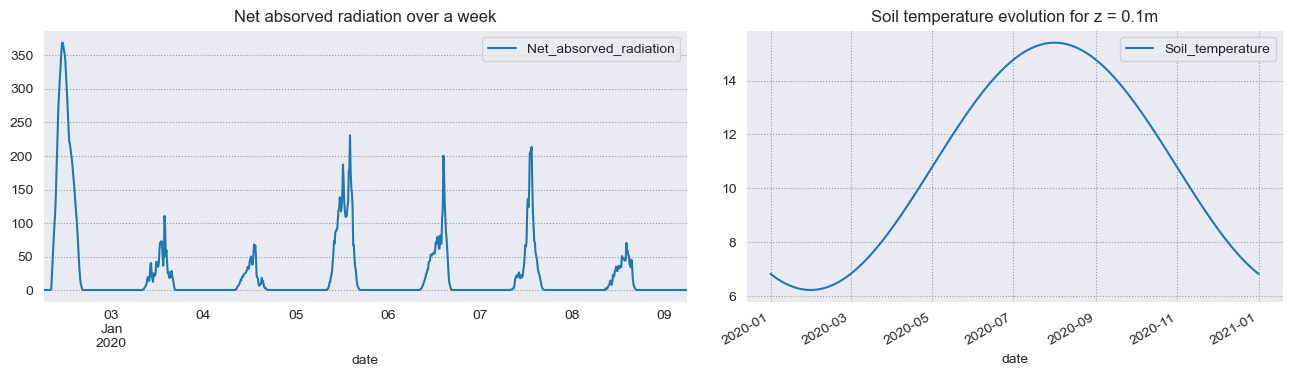

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1.2, 1]})
fig.subplots_adjust(wspace=0.1)
data.iloc[180:180+6*24*7].plot(x="date", y="Net_absorved_radiation", ax=ax[0])
ax[0].set_title("Net absorved radiation over a week")
data.plot(x="date", y="Soil_temperature", ax=ax[1])
ax[1].set_title("Soil temperature evolution for z = 0.1m")
plt.show()